In [3]:
import pandas as pd
import numpy as np
import missingno as msno

---

In [11]:
df_all = pd.read_parquet('data/us_flights_2024_all.parquet')
df_all_sdf = pd.read_parquet('data/us_flights_2024_all_sdf.parquet')

In [10]:
df_all_sdf

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
1179,2024,1,1,8,1,2024-01-08,9E,20363,9E,N695CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180,2024,1,1,9,2,2024-01-09,9E,20363,9E,N538CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1181,2024,1,1,10,3,2024-01-10,9E,20363,9E,N324PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1182,2024,1,1,11,4,2024-01-11,9E,20363,9E,N935XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,2024,1,1,12,5,2024-01-12,9E,20363,9E,N294PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079012,2024,4,12,1,7,2024-12-01,YX,20452,YX,N746YX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7079027,2024,4,12,1,7,2024-12-01,YX,20452,YX,N736YX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7079039,2024,4,12,1,7,2024-12-01,YX,20452,YX,N865RW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7079048,2024,4,12,1,7,2024-12-01,YX,20452,YX,N733YX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

# All-in-one function of cells below

In [6]:
def transform_flight_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and preprocess a raw U.S. flights dataset.

    The function removes redundant identifier and metadata columns,
    drops all columns starting from "FirstDepTime" onward (if present),
    filters out cancelled and diverted flights, and fills missing
    delay-related values with zeros.

    Args:
        df (pd.DataFrame): Raw flights DataFrame containing operational,
            delay, and metadata features.

    Returns:
        pd.DataFrame: Cleaned DataFrame ready for analysis or modeling.
            Cancelled and diverted flights are excluded, and unnecessary
            columns are removed.

    Raises:
        None explicitly. Column removal is tolerant to missing columns.

    Notes:
        - The input DataFrame is copied to avoid in-place modification.
        - Missing delay values are interpreted as no delay and replaced with 0.
    """
    
    df = df.copy()

    col_to_drop = [
        "DOT_ID_Reporting_Airline", "IATA_CODE_Reporting_Airline",
        "OriginAirportID", "OriginAirportSeqID", "OriginCityMarketID",
        "OriginStateFips", "OriginStateName", "OriginWac",
        "DestAirportID", "DestAirportSeqID", "DestCityMarketID",
        "DestStateFips", "DestStateName", "DestWac",
        "Year", "CancellationCode", "Flights"
    ]

    # Drop everything from FirstDepTime onward (if present)
    start_col = "FirstDepTime"
    if start_col in df.columns:
        idx = df.columns.get_loc(start_col)
        df = df.drop(columns=df.columns[idx:], axis=1)

    # Drop columns (ignore missing to avoid KeyError)
    df = df.drop(columns=col_to_drop, errors="ignore")

    # Filter cancelled/diverted flights (avoid extra .copy())
    if {"Cancelled", "Diverted"}.issubset(df.columns):
        df = df.loc[(df["Cancelled"] == 0) & (df["Diverted"] == 0)]
        df = df.drop(columns=["Cancelled", "Diverted"], axis=1)

    # Fill NaNs in delay columns in one shot
    delay_cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
    present_delay_cols = [c for c in delay_cols if c in df.columns]
    if present_delay_cols:
        df[present_delay_cols] = df[present_delay_cols].fillna(0)

    return df

In [7]:
# Transform and save data
df = transform_flight_df(df_all_sdf)
df.to_csv('data/sdf_flights_clean.csv', index=False)

In [8]:
df.columns

Index(['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline',
       'Origin', 'OriginCityName', 'OriginState', 'Dest', 'DestCityName',
       'DestState', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes',
       'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

---

# Use the code below only for testing purposes

---

# Delete all unnecessary columns

In [93]:
df_all_sdf = df_all_sdf.drop(df_all_sdf.columns[61:], axis=1)
df_all_sdf = df_all_sdf.drop(columns=['Year'], axis=1)

In [94]:
drop_1 = ['DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline',
          'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac',
          'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestStateName', 'DestWac']

In [95]:
df_all_sdf = df_all_sdf.drop(columns=drop_1, axis=1)

---

# Delete Cancelled or Diverted flights because its not what we are looking for

In [98]:
df_sdf = df_all_sdf[
    (df_all_sdf['Cancelled'] == 0) &
    (df_all_sdf['Diverted'] == 0)
].copy()

df_sdf = df_sdf.drop(columns=['CancellationCode'], axis=1)
print(df_sdf.shape)


(47640, 45)


In [99]:
df_sdf

,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginCityName,...,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1179,1,1,8,1,2024-01-08,9E,N695CA,4895.0,SDF,"Louisville, KY",...,96.0,58.0,1.0,306.0,2,NaN,NaN,NaN,NaN,NaN
1180,1,1,9,2,2024-01-09,9E,N538CA,4895.0,SDF,"Louisville, KY",...,69.0,48.0,1.0,306.0,2,NaN,NaN,NaN,NaN,NaN
1181,1,1,10,3,2024-01-10,9E,N324PQ,4895.0,SDF,"Louisville, KY",...,75.0,52.0,1.0,306.0,2,NaN,NaN,NaN,NaN,NaN
1182,1,1,11,4,2024-01-11,9E,N935XJ,4895.0,SDF,"Louisville, KY",...,71.0,54.0,1.0,306.0,2,NaN,NaN,NaN,NaN,NaN
1183,1,1,12,5,2024-01-12,9E,N294PQ,4895.0,SDF,"Louisville, KY",...,80.0,54.0,1.0,306.0,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079012,4,12,1,7,2024-12-01,YX,N746YX,3449.0,SDF,"Louisville, KY",...,114.0,55.0,1.0,286.0,2,20.0,0.0,12.0,0.0,0.0
7079027,4,12,1,7,2024-12-01,YX,N736YX,3434.0,SDF,"Louisville, KY",...,94.0,56.0,1.0,286.0,2,NaN,NaN,NaN,NaN,NaN
7079039,4,12,1,7,2024-12-01,YX,N865RW,3422.0,SDF,"Louisville, KY",...,120.0,60.0,1.0,286.0,2,0.0,0.0,16.0,0.0,0.0
7079048,4,12,1,7,2024-12-01,YX,N733YX,3412.0,SDF,"Louisville, KY",...,159.0,102.0,1.0,642.0,3,0.0,0.0,18.0,0.0,0.0


# Fill NaN values with 0 because it`s when there was no delay at all

Axes(0.125,0.11;0.698618x0.77)


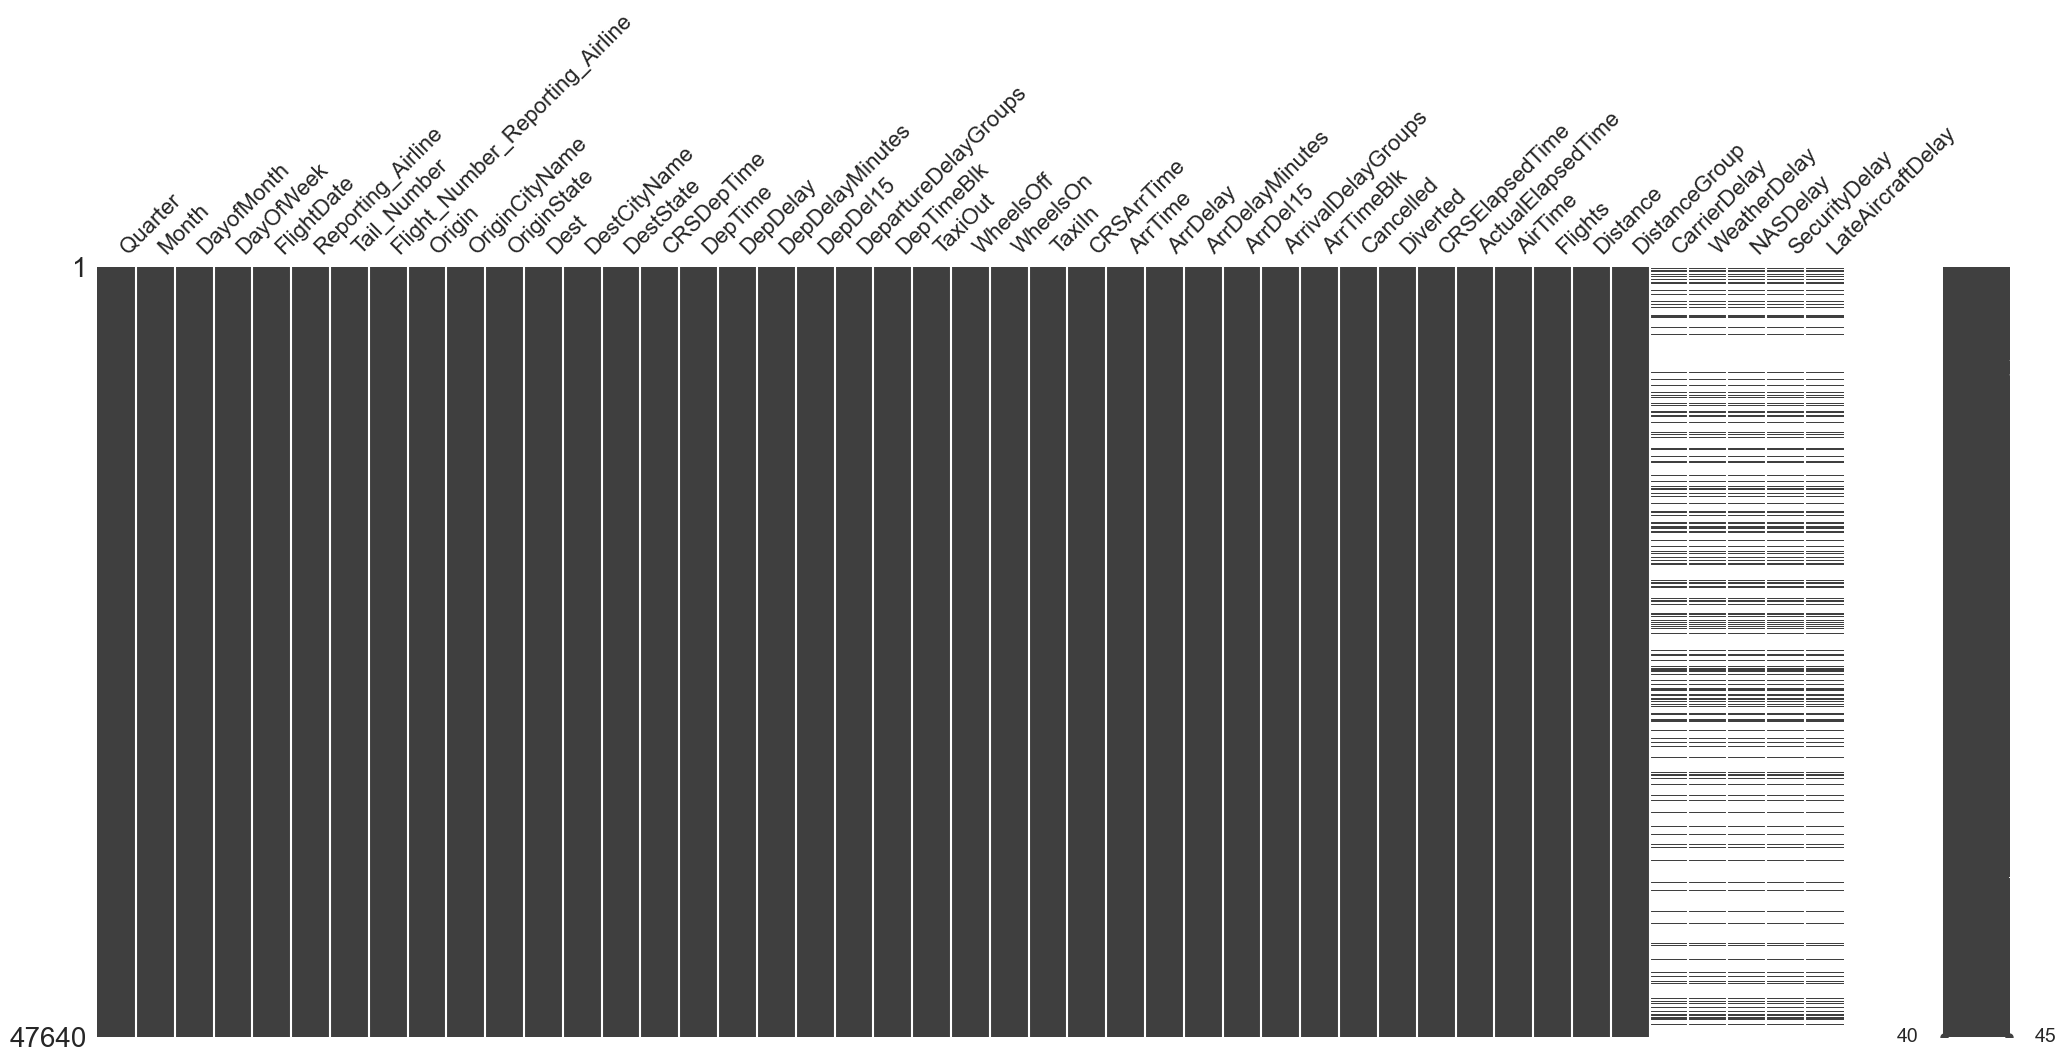

In [100]:
print(msno.matrix(df_sdf))

In [101]:
df_sdf['CarrierDelay'] = df_sdf['CarrierDelay'].fillna(0)
df_sdf['WeatherDelay'] = df_sdf['WeatherDelay'].fillna(0)
df_sdf['NASDelay'] = df_sdf['NASDelay'].fillna(0)
df_sdf['SecurityDelay'] = df_sdf['SecurityDelay'].fillna(0)
df_sdf['LateAircraftDelay'] = df_sdf['LateAircraftDelay'].fillna(0)

In [102]:
df_sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47640 entries, 1179 to 7079053
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Quarter                          47640 non-null  int64  
 1   Month                            47640 non-null  int64  
 2   DayofMonth                       47640 non-null  int64  
 3   DayOfWeek                        47640 non-null  int64  
 4   FlightDate                       47640 non-null  object 
 5   Reporting_Airline                47640 non-null  object 
 6   Tail_Number                      47640 non-null  object 
 7   Flight_Number_Reporting_Airline  47640 non-null  float64
 8   Origin                           47640 non-null  object 
 9   OriginCityName                   47640 non-null  object 
 10  OriginState                      47640 non-null  object 
 11  Dest                             47640 non-null  object 
 12  DestCityName      

In [42]:
#df_sdf.to_csv('data/sdf_flights_clean.csv', index=False)

# Dataset ready to be merged

In [107]:
df_sdf = pd.read_csv('data/sdf_flights_clean.csv')
df_sdf.head()

,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginCityName,...,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,1,8,1,2024-01-08,9E,N695CA,4895.0,SDF,"Louisville, KY",...,96.0,58.0,1.0,306.0,2,0.0,0.0,0.0,0.0,0.0
1,1,1,9,2,2024-01-09,9E,N538CA,4895.0,SDF,"Louisville, KY",...,69.0,48.0,1.0,306.0,2,0.0,0.0,0.0,0.0,0.0
2,1,1,10,3,2024-01-10,9E,N324PQ,4895.0,SDF,"Louisville, KY",...,75.0,52.0,1.0,306.0,2,0.0,0.0,0.0,0.0,0.0
3,1,1,11,4,2024-01-11,9E,N935XJ,4895.0,SDF,"Louisville, KY",...,71.0,54.0,1.0,306.0,2,0.0,0.0,0.0,0.0,0.0
4,1,1,12,5,2024-01-12,9E,N294PQ,4895.0,SDF,"Louisville, KY",...,80.0,54.0,1.0,306.0,2,0.0,0.0,0.0,0.0,0.0


---

---

---

# Delay Info on ALL flights (primary delay cause)

In [18]:
def build_primary_delay_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a summary table of primary delay causes for flight operations.

    The function determines the primary delay cause for each flight based on:
    - Cancellation (highest priority)
    - Diversion
    - On-time arrival (arrival delay < 15 minutes)
    - Maximum delay component among standard delay categories

    It then computes:
    - Number of flights per category
    - Percentage of total operations
    - Total delay minutes attributed to each primary delay cause

    Args:
        df (pd.DataFrame): Flight operations dataset containing delay columns,
            cancellation/diversion indicators, and arrival delay information.

    Returns:
        pd.DataFrame: Summary table indexed by delay category containing:
            - num_flights
            - percent_of_total_flights
            - total_delay_minutes
            - a final "total" row
    """

    df = df.copy()

    # Standard delay component columns
    delay_cols = [
        "CarrierDelay",
        "WeatherDelay",
        "NASDelay",
        "SecurityDelay",
        "LateAircraftDelay",
    ]

    # Step 1: Determine primary delay cause

    # Default: delay type with the maximum delay minutes
    df["primary_delay_cause"] = df[delay_cols].idxmax(axis=1)

    # Apply priority overrides
    conditions = [
        df["Cancelled"] == 1,
        df["Diverted"] == 1,
        (df["Cancelled"] == 0)
        & (df["Diverted"] == 0)
        & (df["ArrDelayMinutes"] < 15),
    ]

    choices = ["Cancelled", "Diverted", "OnTime"]

    df["primary_delay_cause"] = np.select(
        conditions,
        choices,
        default=df["primary_delay_cause"],
    )

    # Step 2: Compute counts and percentages

    total_ops = len(df)

    counts = df["primary_delay_cause"].value_counts()
    percent = (counts / total_ops * 100).round(2)

    # Step 3: Compute total delay minutes per primary cause
    # Only count delay minutes for flights where the delay type matches
    # the identified primary delay cause

    delay_minutes = (
        df.melt(
            id_vars="primary_delay_cause",
            value_vars=delay_cols,
            var_name="delay_type",
            value_name="minutes",
        )
        .query("primary_delay_cause == delay_type")
        .groupby("primary_delay_cause")["minutes"]
        .sum()
    )
    
    # Step 4: Build summary table

    summary = pd.DataFrame(
        {
            "num_flights": counts,
            "percent_of_total_flights": percent,
            "total_delay_minutes": delay_minutes,
        }
    ).fillna(0)

    # Add total row
    summary.loc["total"] = [
        total_ops,
        100.0,
        delay_minutes.sum(),
    ]

    return summary

In [21]:
summary_primary_all = build_primary_delay_summary(df_all)
summary_primary_all

C:\Users\Desmo\AppData\Local\Temp\ipykernel_7896\1022910881.py:46: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["primary_delay_cause"] = df[delay_cols].idxmax(axis=1)


,num_flights,percent_of_total_flights,total_delay_minutes
primary_delay_cause,,,
Cancelled,96315.0,1.36,0.0
CarrierDelay,450784.0,6.37,31990347.0
Diverted,17499.0,0.25,0.0
LateAircraftDelay,571752.0,8.08,38910287.0
NASDelay,369324.0,5.22,15627536.0
OnTime,5515281.0,77.91,0.0
SecurityDelay,3698.0,0.05,134701.0
WeatherDelay,54406.0,0.77,5564031.0
total,7079061.0,100.00,92226902.0


# Delay Info on SDF flights (Primary delay cause)

In [22]:
summary_primary_sdf = build_primary_delay_summary(df_all_sdf)
summary_primary_sdf

C:\Users\Desmo\AppData\Local\Temp\ipykernel_7896\1022910881.py:46: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["primary_delay_cause"] = df[delay_cols].idxmax(axis=1)


,num_flights,percent_of_total_flights,total_delay_minutes
primary_delay_cause,,,
Cancelled,515.0,1.07,0.0
CarrierDelay,2989.0,6.20,228159.0
Diverted,89.0,0.18,0.0
LateAircraftDelay,3399.0,7.05,231863.0
NASDelay,2395.0,4.96,90463.0
OnTime,38446.0,79.69,0.0
SecurityDelay,29.0,0.06,1052.0
WeatherDelay,382.0,0.79,29396.0
total,48244.0,100.00,580933.0


---

In [23]:
summary_primary_full = pd.concat([summary_primary_all, summary_primary_sdf.add_suffix('_sdf')], axis=1)
summary_primary_full

,num_flights,percent_of_total_flights,total_delay_minutes,num_flights_sdf,percent_of_total_flights_sdf,total_delay_minutes_sdf
primary_delay_cause,,,,,,
Cancelled,96315.0,1.36,0.0,515.0,1.07,0.0
CarrierDelay,450784.0,6.37,31990347.0,2989.0,6.20,228159.0
Diverted,17499.0,0.25,0.0,89.0,0.18,0.0
LateAircraftDelay,571752.0,8.08,38910287.0,3399.0,7.05,231863.0
NASDelay,369324.0,5.22,15627536.0,2395.0,4.96,90463.0
OnTime,5515281.0,77.91,0.0,38446.0,79.69,0.0
SecurityDelay,3698.0,0.05,134701.0,29.0,0.06,1052.0
WeatherDelay,54406.0,0.77,5564031.0,382.0,0.79,29396.0
total,7079061.0,100.00,92226902.0,48244.0,100.00,580933.0


In [24]:
summary_primary_full.to_csv('data/summary_primary_full.csv')

---